# Image Captioning with Tensorflow

**Resources:**
- https://medium.com/analytics-vidhya/image-captioning-with-tensorflow-2d72a1d9ffea
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

**Code Contributions:**
 - Got working for TF 2
 - Debugged original code from Medium post which didn't work with copy/paste alone
 - Included inference code in demo
 - Included more output along the way for better code transparency

# Imports

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RepeatVector, Dense, LSTM
from tensorflow.keras.layers import Embedding, Dropout, TimeDistributed, Concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
from PIL import Image

# Image Feature Extraction

- Extract image features by applying ResNet50 (pretrainted on imagenet).
    - Note:  We also omit the last layer (which is the softmax layer) because we only need to extract the features, not to classify the images.
- After executing the code, the output would be a 1x2048 vector for each image, containing the features from the images.

In [21]:
%%time

# Get all filenames of the images
folder = "input/Images/"
images = os.listdir(folder)
print("Total images : ", len(images))
print("Sample image : ", images[0])

# Load the CNN Architecture with Imagenet as weights
image_model = ResNet50(weights='input/Resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model_new = tf.keras.Model(image_model.input,image_model.layers[-2].output)

# Store image features in dictionary
img_features = dict()  
count = 0
for img in images: 
    # print(img)
    img1 = image.load_img(folder + img, target_size=(224, 224))
    # print(img1)
    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # print(x)
    fea_x = model_new.predict(x)
    fea_x1 = np.reshape(fea_x , fea_x.shape[1])
    # print(fea_x1)
    img_features[img] = fea_x1
    count += 1
    # if count == 8092:
    #     break

Total images :  8091
Sample image :  2387197355_237f6f41ee.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━

# Caption Pre-Processing
- The first thing we have to do is gather all of the captions from Flickr8k.Token.txt and group them by a single key, which is the filename. 
- After that, we split the captions for train, validation and test sets according to Flickr_8k.trainImages.txt, Flickr_8k.devImages.txt, and Flickr_8k.testImages.txt.  Those three files only contain the filenames for respective dataset. 
- While splitting the captions based on those files, we also add ‘Startseq’ at the beginning and ‘Endseq’ at the end of the sentence to each caption. This is to signal when the model should start writing or stop predicting next word at training phase.

In [22]:
# Get All Captions
fn = "input/Text/Flickr8k.token.txt"
f = open(fn, 'r')
capts = f.read()
#Group all captions by filename, for references
captions = dict()
i = 0

print("Test")

try:
    for line in capts.split("\n"):
        txt = line.split('\t')
        fn = txt[0].split('#')[0]
        if fn not in captions.keys():
            captions[fn] = [txt[1]]
        else:
            captions[fn].append(txt[1])
        i += 1
except:
    pass #pass Model
    

def getCaptions(path):
    
    f = open(path, 'r')
    capts = f.read()
    desc = dict()

    try:
        for line in capts.split("\n"):
            image_id = line
            image_descs = captions[image_id]

            for des in image_descs:
                ws = des.split(" ")
                w = [word for word in ws if word.isalpha()]
                des = "startseq " + " ".join(w) + " endseq"
                if image_id not in desc:
                    desc[image_id] = list()
                desc[image_id].append(des)
    except:
        pass
    
    return desc

# Split captions
train_caps = getCaptions("input/Text/Flickr_8k.trainImages.txt")
val_caps = getCaptions("input/Text/Flickr_8k.devImages.txt")

Test


#### Review the train_caps & val_caps objects

In [23]:
print("train_caps type: ", type(train_caps))
print("First few (key, value) paris of train_caps:") 
for i, (k, v) in enumerate(train_caps.items()):
    print(k, v)
    if i>2:
        break
print("")
print("val_caps type: ", type(val_caps))
print("First few (key, value) pairs of val_caps:") 
for i, (k, v) in enumerate(val_caps.items()):
    print(k, v)
    if i>2:
        break

train_caps type:  <class 'dict'>
First few (key, value) paris of train_caps:
2513260012_03d33305cf.jpg ['startseq A black dog is running after a white dog in the snow endseq', 'startseq Black dog chasing brown dog through snow endseq', 'startseq Two dogs chase each other across the snowy ground endseq', 'startseq Two dogs play together in the snow endseq', 'startseq Two dogs running through a low lying body of water endseq']
2903617548_d3e38d7f88.jpg ['startseq A little baby plays croquet endseq', 'startseq A little girl plays croquet next to a truck endseq', 'startseq The child is playing croquette by the truck endseq', 'startseq The kid is in front of a car with a put and a ball endseq', 'startseq The little boy is playing with a croquet hammer and ball beside the car endseq']
3338291921_fe7ae0c8f8.jpg ['startseq A brown dog in the snow has something hot pink in its mouth endseq', 'startseq A brown dog in the snow holding a pink hat endseq', 'startseq A brown dog is holding a pink sh

#### Tokenization
- After that, we have to tokenize the captions from the train set and get the word-index & index-word dictionaries from that. 
    - The word-index dictionary is meant to represent the captions as a number to be inputted to the model
    - The index-word is to convert the next word/prediction to the word form, as we know it.

In [24]:
# Preparing to make word-index and index-word
# (adding all training captions to a list)
train_captions = []
for key, desc_list in train_caps.items():
    for i in range(len(desc_list)):
        train_captions.append(desc_list[i])

# Tokenize top 5000 words in Train Captions
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

#### View Tokenizer Indexes

In [25]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(vocab_size))

Vocabulary Size: 7278


In [26]:
print("word_index type: ", type(word_index))
print("First few (key, value) paris of word_index:") 
for i, (k, v) in enumerate(word_index.items()):
    print(k, v)
    if i>2:
        break
print("")
print("index_word type: ", type(index_word))
print("First few (key, value) pairs of index_word:") 
for i, (k, v) in enumerate(index_word.items()):
    print(k, v)
    if i>2:
        break

word_index type:  <class 'dict'>
First few (key, value) paris of word_index:
<unk> 1
a 2
startseq 3
endseq 4

index_word type:  <class 'dict'>
First few (key, value) pairs of index_word:
1 <unk>
2 a
3 startseq
4 endseq


#### Images + Image Features

In [27]:
%%time

train_fns = list(train_caps.keys())
train_set = dict((k, img_features[k]) for k in train_fns)
val_fns = list(val_caps.keys())
val_set = dict((k, img_features[k]) for k in val_fns)
fn_test = "input/Text/Flickr_8k.testImages.txt"
# fn_test = "input/Text/Flickr_8k.testImages[Tiny].txt"
f = open(fn_test, 'r')
t = f.read()

test_fns= t.split("\n")
test_set = dict((k, img_features[k]) for k in list(test_fns[:-1]))

# print(test_set.shape)
# print(test_set)

print("train_set type: ", type(train_set))
print("First few (key, value) paris of train_set:") 
for i, (k, v) in enumerate(train_set.items()):
    print(k, v)
    if i>2:
        break
print("")
print("val_set type: ", type(val_set))
print("First few (key, value) pairs of val_set:") 
for i, (k, v) in enumerate(val_set.items()):
    print(k, v)
    if i>2:
        break
print("")
print("test_set type: ", type(test_set))
print("First few (key, value) pairs of test_set:") 
for i, (k, v) in enumerate(test_set.items()):
    print(k, v)
    if i>2:
        break

train_set type:  <class 'dict'>
First few (key, value) paris of train_set:
2513260012_03d33305cf.jpg [0.3470798  0.51159143 0.08728845 ... 1.1897292  0.04043846 0.15271093]
2903617548_d3e38d7f88.jpg [0.         0.00307801 0.09359977 ... 0.43103462 0.3798527  0.9165756 ]
3338291921_fe7ae0c8f8.jpg [0.7674458  0.53422654 0.38325182 ... 0.02098668 0.18429385 0.0427001 ]
488416045_1c6d903fe0.jpg [6.2481111e-01 3.2965460e-01 1.7816680e-04 ... 1.2753804e+00 4.6392518e-01
 4.9036041e-01]

val_set type:  <class 'dict'>
First few (key, value) pairs of val_set:
2090545563_a4e66ec76b.jpg [0.19071406 0.23291132 0.         ... 0.01300225 1.4703312  0.03179046]
3393035454_2d2370ffd4.jpg [0.0204954  0.49463874 0.69344753 ... 0.         0.09734627 0.        ]
3695064885_a6922f06b2.jpg [0.26762378 0.61937493 0.01225698 ... 0.38134953 1.835974   1.2442313 ]
1679557684_50a206e4a9.jpg [0.5639574  0.4630029  0.4788954  ... 0.4153412  0.86708343 0.23478808]

test_set type:  <class 'dict'>
First few (key, val

#### View train_set, val_set, test_set

In [28]:
# =============================================================================
#       Moved this section above
# =============================================================================
# 
# print("train_set type: ", type(train_set))
# print("First few (key, value) paris of train_set:") 
# for i, (k, v) in enumerate(train_set.items()):
#     print(k, v)
#     if i>2:
#         break
# print("")
# print("val_set type: ", type(val_set))
# print("First few (key, value) pairs of val_set:") 
# for i, (k, v) in enumerate(val_set.items()):
#     print(k, v)
#     if i>2:
#         break
# print("")
# print("test_set type: ", type(test_set))
# print("First few (key, value) pairs of test_set:") 
# for i, (k, v) in enumerate(test_set.items()):
#     print(k, v)
#     if i>2:
#         break

# Final Training & Validation Data

In [29]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [30]:
max_length = 34

In [31]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield (in_img, in_seq), out_word

In [32]:
# test the data generator
generator = data_generator(train_caps, train_set, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(50, 2048)
(50, 34)
(50, 7278)


# Word Embedding Matrix
- For this project, we used GloVe Word Embedding for the captions. Every word in the dictionary will be mapped into a vector from the pre-trained GloVe model. The dimension of GloVe we used is 200.
- According to GloVe website, GloVe has been modeled by how frequently a word is coming up after another word. So, we expect that the predicted caption can be improved with this.
- First, we collect all the words in GloVe and their coefficients. Then, we map all the words in our dictionaries before to a vector and collect all of them into a matrix (embedding matrix)

In [33]:
%%time

# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open("input/Glove/glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
vocab_size = len(word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.
CPU times: user 7.13 s, sys: 590 ms, total: 7.72 s
Wall time: 9.3 s


# Model Architecture
- For the model architecture, there are two parts at the beginning. 
- The first one is handling the image feature (image_model), which consists a Dense layer and RepeatVector. 
- The second part is the one handling the captions (language_model). 
    - At the first layer of language_model, there is an Embedding layer, which weight will be assigned by the GloVe coefficients we have gathered before in embedding_matrix. We also set that layer to be untrainable, since it has been pre-trained before.
- Next, the image_model and language_model are concatenated to predict the next word (output). 
    - For the next-word prediction part, there are 2 layers of LSTM followed by a Dense and Softmax layer for classification (since this case is a multi-class classification anyway).

In [34]:
image_input = Input(shape=(2048,))
image_model = Dense(embedding_dim, activation='relu')(image_input)
image_model = RepeatVector(max_length)(image_model)
print(image_model.shape)
print(image_model)

language_input = Input(shape=(max_length,))
language_model = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(language_input)
language_model = LSTM(256, return_sequences=True)(language_model)
language_model = TimeDistributed(Dense(embedding_dim))(language_model)
print(language_model.shape)
print(language_model)

conca = Concatenate()([image_model, language_model])
print(conca.shape)
print(conca)
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
print(x.shape)
print(x)
out = Activation('softmax')(x)
model_1 = Model(inputs=[image_input, language_input], outputs=out)

model_1.layers[2].set_weights([embedding_matrix])
model_1.layers[2].trainable = False

model_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(model_1.summary())

# Ensure train_set is defined
train_fns = list(train_caps.keys())
train_set = dict((k, img_features[k]) for k in train_fns)

(None, 34, 200)
<KerasTensor shape=(None, 34, 200), dtype=float32, sparse=False, name=keras_tensor_179>
(None, 34, 200)
<KerasTensor shape=(None, 34, 200), dtype=float32, sparse=False, name=keras_tensor_183>
(None, 34, 400)
<KerasTensor shape=(None, 34, 400), dtype=float32, sparse=False, name=keras_tensor_184>
(None, 7278)
<KerasTensor shape=(None, 7278), dtype=float32, sparse=False, name=keras_tensor_187>


/Users/jaredf/anaconda3/envs/kaggle-env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 200)   │  1,455,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    409,800 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 34, 256)   │    467,968 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 34, 200)   │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 34, 200)   │     51,400 │ lstm[0][0]        │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 34, 400)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 34, 128)   │    270,848 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 512)       │  1,312,768 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7278)      │  3,733,614 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7278)      │          0 │ dense_2[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,701,998 (29.38 MB)

 Trainable params: 6,246,398 (23.83 MB)

 Non-trainable params: 1,455,600 (5.55 MB)

None


# Training

In [36]:
%%time


# train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_caps)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_caps, train_set, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model_1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


   8/6000 ━━━━━━━━━━━━━━━━━━━━ 22:19 224ms/step - accuracy: 0.1072 - loss: 7.9760

KeyboardInterrupt: 

# Inference

**Pseudo-Code:**
- For Each Image
    - KeepAddingWords = True
    - While KeepAddingWords:
        - yhat = model.predict([image_features,caption_sequence_so_far])
        - if yhat is Endseq:
            - KeepAddingWords = False
        - Else:
            - append yhat to caption_sequence_so_far

In [37]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    return tokenizer.index_word.get(integer)

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #print("sequence after tok: ", sequence)
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        if i==0:
            photo = np.expand_dims(photo, axis=0)
        #print("photo: ", photo)
        #print("sequence: ", sequence)
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [38]:
# test the predict function
photo = list(test_set.values())[0] # First image in testing set
tmpimg1 = np.expand_dims(np.array(photo), axis=0)
print(tmpimg1.shape)
tmpcap1 = pad_sequences([[3]], maxlen=max_length)
print(tmpcap1.shape)
tmpout1 = model_1.predict([tmpimg1, tmpcap1], verbose=0)
print(tmpout1.shape)
print(tmpout1)

(1, 2048)
(1, 34)
(1, 7278)
[[2.0722185e-04 1.5801164e-04 3.8088742e-03 ... 8.2547595e-05
  2.0735548e-04 1.2145742e-04]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Caption: startseq a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


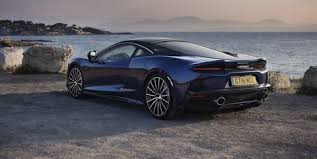

In [39]:
def image_to_feat_vec(imagePath):
    img1 = image.load_img(imagePath, target_size=(224, 224))
    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    fea_x = model_new.predict(x)
    fea_x1 = np.reshape(fea_x , fea_x.shape[1])
    return fea_x1

imagePath = "input/Garage/GarageImages/GarageImages/image1086.jpg"
photo = image_to_feat_vec(imagePath)
print("Predicted Caption:", generate_desc(model_1, tokenizer, photo, max_length))
Image.open(imagePath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Caption: startseq a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


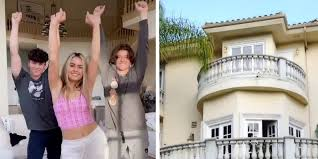

In [40]:
imagePath = "input/Garage/GarageImages/GarageImages/image1185.jpg"
photo = image_to_feat_vec(imagePath)
print("Predicted Caption:", generate_desc(model_1, tokenizer, photo, max_length))
Image.open(imagePath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Caption: startseq a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


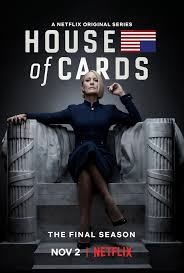

In [41]:
imagePath = "input/Garage/GarageImages/GarageImages/image1396.jpg"
photo = image_to_feat_vec(imagePath)
print("Predicted Caption:", generate_desc(model_1, tokenizer, photo, max_length))
Image.open(imagePath)

In [42]:
# ==========================================================================================================================================

# USE THIS CELL TO CONVERT YOUR MODEL TO A TENSORFLOW LITE MODEL

# ==========================================================================================================================================

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] #\n converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model to disk
open("caption_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)

# Indicate that we want to perform the default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] #\n converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model to disk
open("caption_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmp0wltkr6y/assets


INFO:tensorflow:Assets written to: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmp0wltkr6y/assets


Saved artifact at '/var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmp0wltkr6y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2048), dtype=tf.float32, name='keras_tensor_177'), TensorSpec(shape=(None, 34), dtype=tf.float32, name='keras_tensor_180')]
Output Type:
  TensorSpec(shape=(None, 7278), dtype=tf.float32, name=None)
Captures:
  12222480848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222483344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11114413520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11114413904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222484496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482768: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1733945137.349497   21090 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733945137.350301   21090 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-11 11:25:37.351401: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmp0wltkr6y
2024-12-11 11:25:37.352782: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-11 11:25:37.352788: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmp0wltkr6y
I0000 00:00:1733945137.369059   21090 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-12-11 11:25:37.370869: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-11 11:25:37.467582: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

INFO:tensorflow:Assets written to: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj/assets


INFO:tensorflow:Assets written to: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj/assets


Saved artifact at '/var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2048), dtype=tf.float32, name='keras_tensor_177'), TensorSpec(shape=(None, 34), dtype=tf.float32, name='keras_tensor_180')]
Output Type:
  TensorSpec(shape=(None, 7278), dtype=tf.float32, name=None)
Captures:
  12222480848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222483344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11114413520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11114413904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222484496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12222482768: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1733945139.353648   21090 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733945139.353658   21090 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-11 11:25:39.353767: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj
2024-12-11 11:25:39.355006: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-11 11:25:39.355011: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj
2024-12-11 11:25:39.371389: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-11 11:25:39.447958: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/jh/7fx50dyx3q534l7th72xbgr40000gn/T/tmpbddu3nlj
2024-12-11 11:25:39.476826: I tensorflow/cc/saved_model/loader.cc:

7967024

In [43]:
# Install required packages
# !pip install -U pip setuptools wheel
# !pip install numpy torch torchvision scikit-learn nltk rouge-score spacy
# !python -m spacy download en_core_web_sm

# Import required packages and download necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Verify installations
import torch
import numpy as np
from sklearn.metrics import accuracy_score
import spacy
from rouge_score import rouge_scorer

print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("SpaCy version:", spacy.__version__)

# Test SpaCy model loading
nlp = spacy.load('en_core_web_sm')
print("SpaCy model loaded successfully!")

print("\nAll dependencies installed and verified!")

[nltk_data] Downloading package punkt to /Users/jaredf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jaredf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jaredf/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


PyTorch version: 2.5.1
NumPy version: 1.26.4
SpaCy version: 3.7.5


/Users/jaredf/anaconda3/envs/kaggle-env/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


SpaCy model loaded successfully!

All dependencies installed and verified!


In [44]:
# Install additional visualization packages
# !pip install matplotlib seaborn plotly pandas

# Import and test
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

print("Visualization packages installed successfully!")

Visualization packages installed successfully!


In [45]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from typing import Dict, List, Tuple, Optional, Union
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.ribes_score import sentence_ribes
from rouge_score import rouge_scorer
import spacy
import editdistance
from collections import Counter

class ModelEvaluator:
    def __init__(self, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.nlp = spacy.load('en_core_web_sm')
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def compute_accuracy(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:

        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        return accuracy_score(targets.cpu(), predictions.cpu())

    def compute_precision_recall_f1(self, predictions: torch.Tensor,
                                  targets: torch.Tensor,
                                  average: str = 'weighted') -> Tuple[float, float, float]:

        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets.cpu(), predictions.cpu(), average=average
        )
        return precision, recall, f1

    def compute_cross_entropy_loss(self, predictions: torch.Tensor,
                                 targets: torch.Tensor,
                                 reduction: str = 'mean') -> float:

        loss_fn = nn.CrossEntropyLoss(reduction=reduction)
        return loss_fn(predictions, targets).item()

    def compute_auc_roc(self, predictions: torch.Tensor,
                       targets: torch.Tensor,
                       multi_class: str = 'ovr') -> float:

        if predictions.dim() == 1:
            predictions = F.softmax(predictions.unsqueeze(1), dim=1)
        else:
            predictions = F.softmax(predictions, dim=1)
        return roc_auc_score(targets.cpu(), predictions.cpu(), multi_class=multi_class)

    def compute_map(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:

        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        return average_precision_score(targets.cpu(), predictions.cpu())

    def compute_inference_time(self, model: nn.Module,
                             input_data: Union[torch.Tensor, Tuple[torch.Tensor, ...]],
                             num_runs: int = 100) -> Dict[str, float]:

        model.eval()
        model.to(self.device)

        if isinstance(input_data, tuple):
            input_data = tuple(x.to(self.device) for x in input_data)
        else:
            input_data = input_data.to(self.device)

        times = []
        with torch.no_grad():
            for _ in range(num_runs):
                start_time = time.time()
                _ = model(input_data)
                end_time = time.time()
                times.append(end_time - start_time)

        return {
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'min_time': np.min(times),
            'max_time': np.max(times)
        }

    def compute_confusion_matrix(self, predictions: torch.Tensor,
                               targets: torch.Tensor) -> np.ndarray:
        if predictions.dim() > 1:
            predictions = predictions.argmax(dim=1)
        return confusion_matrix(targets.cpu(), predictions.cpu())

    def compute_bleu(self,
                    candidate: str,
                    references: List[str],
                    weights: Tuple[float, ...] = (0.25, 0.25, 0.25, 0.25)) -> float:

        candidate = candidate.lower().split()
        references = [[ref.lower().split()] for ref in references]
        smoothing = SmoothingFunction().method1
        return sentence_bleu(references, candidate, weights=weights, smoothing_function=smoothing)

    def compute_meteor(self, candidate: str, references: List[str]) -> float:

        return meteor_score(references, candidate)

    def compute_rouge(self, candidate: str, reference: str) -> Dict[str, float]:

        scores = self.rouge_scorer.score(reference, candidate)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }

    def compute_cider(self, candidate: str, references: List[str]) -> float:

        def preprocess_sentence(sentence):
            doc = self.nlp(sentence.lower())
            return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

        def compute_tf_idf(sentences):
            df = Counter()
            for sentence in sentences:
                df.update(set(sentence))

            # Compute TF-IDF vectors
            n_sentences = len(sentences)
            vectors = []
            for sentence in sentences:
                vec = Counter(sentence)
                for word in vec:
                    vec[word] *= np.log(n_sentences / (df[word] + 1))
                vectors.append(vec)
            return vectors

        # Preprocess candidate and references
        candidate_tokens = preprocess_sentence(candidate)
        reference_tokens = [preprocess_sentence(ref) for ref in references]

        all_sentences = [candidate_tokens] + reference_tokens
        vectors = compute_tf_idf(all_sentences)

        # Compute cosine similarity between candidate and references
        candidate_vec = vectors[0]
        reference_vecs = vectors[1:]

        similarities = []
        for ref_vec in reference_vecs:
            dot_product = sum(candidate_vec[word] * ref_vec.get(word, 0)
                            for word in candidate_vec)
            norm1 = np.sqrt(sum(val**2 for val in candidate_vec.values()))
            norm2 = np.sqrt(sum(val**2 for val in ref_vec.values()))

            if norm1 == 0 or norm2 == 0:
                similarities.append(0)
            else:
                similarities.append(dot_product / (norm1 * norm2))

        return np.mean(similarities) * 10  # Scale to 0-10 range

    def compute_spice(self, candidate: str, reference: str) -> float:

        def extract_semantic_props(text):
            doc = self.nlp(text)
            props = []

            # Extract subject-verb-object triples
            for token in doc:
                if token.dep_ in ('nsubj', 'nsubjpass'):
                    subject = token.text
                    verb = token.head.text
                    obj = None
                    for child in token.head.children:
                        if child.dep_ in ('dobj', 'pobj'):
                            obj = child.text
                            break
                    if obj:
                        props.append((subject, verb, obj))

            for token in doc:
                if token.dep_ == 'amod':
                    props.append((token.head.text, 'has_attribute', token.text))

            return set(props)

        candidate_props = extract_semantic_props(candidate)
        reference_props = extract_semantic_props(reference)

        # callculate F1 score
        if not candidate_props or not reference_props:
            return 0.0

        intersection = len(candidate_props & reference_props)
        precision = intersection / len(candidate_props) if candidate_props else 0
        recall = intersection / len(reference_props) if reference_props else 0

        if precision + recall == 0:
            return 0.0

        f1 = 2 * (precision * recall) / (precision + recall)
        return f1

    def evaluate_model(self, model: nn.Module,
                      dataloader: torch.utils.data.DataLoader,
                      metrics: List[str] = None) -> Dict[str, float]:

        if metrics is None:
            metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'cross_entropy', 'map']

        model.eval()
        model.to(self.device)

        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, (tuple, list)):
                    inputs = tuple(x.to(self.device) for x in batch[:-1])
                    targets = batch[-1].to(self.device)
                else:
                    inputs = batch[0].to(self.device)
                    targets = batch[1].to(self.device)

                predictions = model(inputs)
                all_predictions.append(predictions)
                all_targets.append(targets)

        all_predictions = torch.cat(all_predictions)
        all_targets = torch.cat(all_targets)

        results = {}

        for metric in metrics:
            if metric == 'accuracy':
                results['accuracy'] = self.compute_accuracy(all_predictions, all_targets)
            elif metric in ['precision', 'recall', 'f1']:
                p, r, f1 = self.compute_precision_recall_f1(all_predictions, all_targets)
                results['precision'] = p
                results['recall'] = r
                results['f1'] = f1
            elif metric == 'auc_roc':
                results['auc_roc'] = self.compute_auc_roc(all_predictions, all_targets)
            elif metric == 'cross_entropy':
                results['cross_entropy'] = self.compute_cross_entropy_loss(all_predictions, all_targets)
            elif metric == 'map':
                results['map'] = self.compute_map(all_predictions, all_targets)

        return results

    def evaluate_captions(self,
                         candidates: List[str],
                         references: List[List[str]],
                         metrics: List[str] = None) -> Dict[str, float]:
        if metrics is None:
            metrics = ['bleu', 'meteor', 'rouge', 'cider', 'spice']

        results = {}

        for metric in metrics:
            scores = []

            for candidate, refs in zip(candidates, references):
                if metric == 'bleu':
                    score = self.compute_bleu(candidate, refs)
                elif metric == 'meteor':
                    score = self.compute_meteor(candidate, refs)
                elif metric == 'rouge':
                    rouge_scores = self.compute_rouge(candidate, refs[0])
                    for rouge_type, value in rouge_scores.items():
                        if f'rouge_{rouge_type}' not in results:
                            results[f'rouge_{rouge_type}'] = []
                        results[f'rouge_{rouge_type}'].append(value)
                    continue
                elif metric == 'cider':
                    score = self.compute_cider(candidate, refs)
                elif metric == 'spice':
                    score = self.compute_spice(candidate, refs[0])

                scores.append(score)

            if metric != 'rouge':
                results[metric] = np.mean(scores)

        # Average ROUGE scores
        for rouge_type in results:
            if rouge_type.startswith('rouge_'):
                results[rouge_type] = np.mean(results[rouge_type])

        return results

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Optional
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class EvaluationVisualizer:
    def __init__(self, style: str = 'seaborn'):

        self.style = style
        plt.style.use('seaborn')

    def plot_metric_comparison(self,
                             metrics_dict: Dict[str, List[float]],
                             model_names: List[str],
                             title: str = "Model Comparison",
                             figsize: tuple = (10, 6)) -> None:

        plt.figure(figsize=figsize)

        x = np.arange(len(model_names))
        width = 0.8 / len(metrics_dict)

        for i, (metric_name, values) in enumerate(metrics_dict.items()):
            plt.bar(x + i * width, values, width, label=metric_name)

        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title(title)
        plt.xticks(x + width * (len(metrics_dict) - 1) / 2, model_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_metric_history(self,
                          metric_history: Dict[str, List[float]],
                          title: str = "Metric History",
                          figsize: tuple = (10, 6)) -> None:

        plt.figure(figsize=figsize)

        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name, marker='o')

        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self,
                            conf_matrix: np.ndarray,
                            class_names: Optional[List[str]] = None,
                            title: str = "Confusion Matrix",
                            figsize: tuple = (8, 6)) -> None:

        plt.figure(figsize=figsize)

        if class_names is None:
            class_names = [f'Class {i}' for i in range(len(conf_matrix))]

        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_caption_metrics_radar(self,
                                 metrics: Dict[str, float],
                                 title: str = "Caption Quality Metrics",
                                 figsize: tuple = (10, 10)) -> None:

        if self.style == 'plotly':
            categories = list(metrics.keys())
            values = list(metrics.values())

            fig = go.Figure(data=[go.Scatterpolar(
                r=values + [values[0]],
                theta=categories + [categories[0]],
                fill='toself'
            )])

            fig.update_layout(
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                        range=[0, max(values) * 1.2]
                    )),
                showlegend=False,
                title=title
            )
            fig.show()
        else:
            # Matplotlib version
            categories = list(metrics.keys())
            values = list(metrics.values())

            angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
            values = np.concatenate((values, [values[0]]))
            angles = np.concatenate((angles, [angles[0]]))

            fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
            ax.plot(angles, values)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories)
            plt.title(title)
            plt.show()

    def plot_caption_length_distribution(self,
                                      captions: List[str],
                                      title: str = "Caption Length Distribution",
                                      figsize: tuple = (10, 6)) -> None:

        lengths = [len(caption.split()) for caption in captions]

        plt.figure(figsize=figsize)
        sns.histplot(lengths, bins=30, kde=True)
        plt.xlabel('Number of Words')
        plt.ylabel('Frequency')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_metric_correlation(self,
                              metrics_data: Dict[str, List[float]],
                              title: str = "Metric Correlations",
                              figsize: tuple = (10, 8)) -> None:

        df = pd.DataFrame(metrics_data)
        correlation_matrix = df.corr()

        plt.figure(figsize=figsize)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_interactive_caption_comparison(self,
                                         candidates: List[str],
                                         references: List[List[str]],
                                         metrics: Dict[str, List[float]],
                                         title: str = "Caption Comparison") -> None:
        if self.style != 'plotly':
            print("This visualization requires plotly style.")
            return

        fig = make_subplots(rows=2, cols=1,
                           subplot_titles=("Metric Scores", "Caption Text"),
                           row_heights=[0.7, 0.3])

        # Add metrics visualization
        for metric_name, values in metrics.items():
            fig.add_trace(
                go.Bar(name=metric_name, x=list(range(len(values))), y=values),
                row=1, col=1
            )

        # Add caption text
        caption_text = []
        for i, (cand, refs) in enumerate(zip(candidates, references)):
            caption_text.append(f"Generated {i}: {cand}<br>References: {'; '.join(refs)}")

        fig.add_trace(
            go.Table(
                header=dict(values=["Captions"]),
                cells=dict(values=[caption_text])
            ),
            row=2, col=1
        )

        fig.update_layout(height=800, title_text=title)
        fig.show()

In [ ]:
tflite_model_path = "caption_model.tflite"
tflite_quantized_model_path = "caption_model_quantized.tflite"

tflite_model = tf.lite.Interpreter(model_path=tflite_model_path)
model_q = tf.lite.Interpreter(model_path=tflite_quantized_model_path)

candidate = generate_desc(model_1, tokenizer, photo, max_length)
print("Candidate: ", candidate)
print(val_caps)
print(list(val_caps.keys())[1])
print(val_caps.keys())

references = val_caps[list(val_caps.keys())[1]]
print("References: ", references)

m1_input = model_1.input
print("\nInput: ")
print(m1_input)
print(model_1.input_shape)

m1_output = model_1.output
print("\nOutput: ")
print(m1_output)
print(model_1.output_shape)

qCandidate = generate_desc(model_q, tokenizer, photo, max_length)

print("\n==========================================================================================================")

weights = [0.25, 0.25, 0.25, 0.25]
bleu_score = compute_bleu(candidate, references, [weights])
meteor_score = compute_meteor(candidate, references)
rouge_score = compute_rouge(candidate, references[0])
cider_score = compute_cider(candidate, references)
spice_score = compute_spice(candidate, references[0])

q_bleu_score = compute_bleu(candidate, references, [weights])
q_meteor_score = compute_meteor(candidate, references)
q_rouge_score = compute_rouge(candidate, references[0])
q_cider_score = compute_cider(candidate, references)
q_spice_score = compute_spice(candidate, references[0])

# compute_accuracy(model_1, inputs, outputs)

print("\nBleu Score: ", bleu_score)
print("Meteor Score: ", meteor_score)
print("Rouge Score: ", rouge_score)
print("Cider Score: ", cider_score)
print("Spice Score: ", spice_score)

print("\nQuantized Bleu Score: ", q_bleu_score)
print("Quantized Meteor Score: ", q_meteor_score)
print("Quantized Rouge Score: ", q_rouge_score)
print("Quantized Cider Score: ", q_cider_score)
print("Quantized Spice Score: ", q_spice_score)

print("==========================================================================================================")
print(model_1.summary())

In [ ]:
# from nltk.translate.bleu_score import corpus_bleu

# # def evaluate_model(self, model: nn.Module,
# #                       dataloader: torch.utils.data.DataLoader,
# #                       metrics: List[str] = None) -> Dict[str, float]:

# bleu4 = corpus_bleu(references, candidate)
# print("BLEU-4 Score: ", bleu4)

# # evaluator = ModelEvaluator()

# # flickr8k_metrics = evaluate_model(
# #     model_1,
# #     flickr8k_test_loader,
# #     metrics=['bleu', 'meteor', 'rouge', 'cider', 'spice'],
# # )